# Amazon Fine Food Reviews - Clustering with KMeans and Agglomerative

## Libraries

In [1]:
import pandas as pd
import re, string

import spacy
import nltk

nltk.download('punkt')
nltk.download('stopwords')

nlp = spacy.load('en_core_web_sm')

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

stop_words = set(stopwords.words('english'))

from sklearn.feature_extraction.text import CountVectorizer

from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.cluster import KMeans

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\madab\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\madab\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Importing the data set

In [2]:
n = 10000

raw_reviews = pd.read_csv("./dataset/Reviews.csv", nrows=n)

raw_reviews

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...
...,...,...,...,...,...,...,...,...,...,...
9995,9996,B000P41A28,A3A63RACXR1XIL,"A. Boodhoo ""deaddodo""",10,15,1,1204502400,constipation,we switched from the advance similac to the or...
9996,9997,B000P41A28,A5VVRGL8JA7R,Adam,2,3,5,1306368000,Constipation Not A Problem if...,"Like the bad reviews say, the organic formula ..."
9997,9998,B000P41A28,A2TGDTJ8YCU6PD,geena77,0,0,5,1347494400,Love this formula!,I wanted to solely breastfeed but was unable t...
9998,9999,B000P41A28,AUV4GIZZE693O,"Susan Coe ""sueysis""",1,2,5,1203638400,very convenient,i love the fact that i can get this delieved t...


## Preprocessing

1. Removing duplicates

In [3]:
raw_reviews.shape

(10000, 10)

In [4]:
# before removing duplicates: shape = (10000, 10)

reviews = raw_reviews.drop_duplicates()
reviews.shape

(10000, 10)

In [5]:
# after removing duplicates we have the same shape, so no duplicates in the dataset
# we want to analyze the data for duplicates by "UserId", "ProfileName", "Time", "Text"
# because these elements should have unique values

reviews = raw_reviews.drop_duplicates(subset={"UserId", "ProfileName", "Time","Text"})
reviews.shape

(9515, 10)

2. Analysing the score

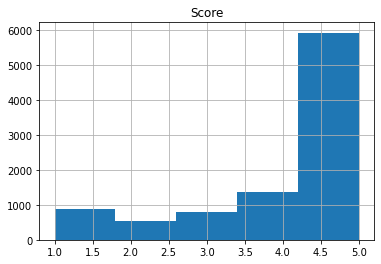

In [6]:
reviews.hist(column='Score',bins=5);

We observe we have a larger number of positive reviews compared to the negative ones. We may need to modify this, to be seen.

3. Preprocessing

In [7]:
# visualizing how the texts look

reviews["Text"].values

array(['I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador is finicky and she appreciates this product better than  most.',
       'Product arrived labeled as Jumbo Salted Peanuts...the peanuts were actually small sized unsalted. Not sure if this was an error or if the vendor intended to represent the product as "Jumbo".',
       'This is a confection that has been around a few centuries.  It is a light, pillowy citrus gelatin with nuts - in this case Filberts. And it is cut into tiny squares and then liberally coated with powdered sugar.  And it is a tiny mouthful of heaven.  Not too chewy, and very flavorful.  I highly recommend this yummy treat.  If you are familiar with the story of C.S. Lewis\' "The Lion, The Witch, and The Wardrobe" - this is the treat that seduces Edmund into selling out his Brother and Sisters to the Witch.',
    

In [8]:
# we observe from the above section that we have html tags and punctuation that we need to eliminate

processed_reviews = []

for review in reviews["Text"].values:
    # we first eliminate the html tags
    no_html = re.compile('<.*?>')
    text = re.sub(no_html, '', review)
    
    # then we eliminate the punctuation signs
    text = text.translate(str.maketrans('', '', string.punctuation))
    
    processed_reviews.append(text)
    
processed_reviews    

['I have bought several of the Vitality canned dog food products and have found them all to be of good quality The product looks more like a stew than a processed meat and it smells better My Labrador is finicky and she appreciates this product better than  most',
 'Product arrived labeled as Jumbo Salted Peanutsthe peanuts were actually small sized unsalted Not sure if this was an error or if the vendor intended to represent the product as Jumbo',
 'This is a confection that has been around a few centuries  It is a light pillowy citrus gelatin with nuts  in this case Filberts And it is cut into tiny squares and then liberally coated with powdered sugar  And it is a tiny mouthful of heaven  Not too chewy and very flavorful  I highly recommend this yummy treat  If you are familiar with the story of CS Lewis The Lion The Witch and The Wardrobe  this is the treat that seduces Edmund into selling out his Brother and Sisters to the Witch',
 'If you are looking for the secret ingredient in R

In [9]:
# we deleted all special characters, now we process the words

new_reviews = []
for review in processed_reviews:
    # tokenize word for further processing
    text = word_tokenize(review)
    
    # make all letters lowercase
    new_text = []
    for word in text:
        cuv = word.lower()
        new_text.append(cuv)
    text = new_text
    
    # remove stop words
    new_text = []
    for word in text:
        if word not in stop_words:
            new_text.append(word)
    text = new_text
    
    # lemmatization
    text = " ".join(text)
    text = nlp(text)
    new_text = []
    for word in text:
        new_text.append(word.lemma_)
    text = " ".join(new_text)
    
    new_reviews.append(text)

new_reviews


['buy several vitality can dog food product find good quality product look like stew process meat smell well labrador finicky appreciate product well',
 'product arrive label jumbo salt peanutsthe peanut actually small sized unsalted sure error vendor intend represent product jumbo',
 'confection around century light pillowy citrus gelatin nuts case filbert cut tiny square liberally coat powdered sugar tiny mouthful heaven chewy flavorful highly recommend yummy treat familiar story cs lewis lion witch wardrobe treat seduce edmund sell brother sister witch',
 'look secret ingredient robitussin believe find get addition root beer extract order good make cherry soda flavor medicinal',
 'great taffy great price wide assortment yummy taffy delivery quick taffy lover deal',
 'get wild hair taffy order five pound bag taffy enjoyable many flavor watermelon root beer melon peppermint grape etc complaint bit much redblack licoriceflavore piece particular favorite kid husband last two week would 

## Features

1. Bag of Words

In [10]:
processed_reviews = new_reviews

# Bag of Words

vector_bow = CountVectorizer()

bag_of_words = vector_bow.fit_transform(processed_reviews)

2. TF-IDF

In [11]:
# TD-IDF

vector_tfidf = TfidfVectorizer()

tfidf = vector_tfidf.fit_transform(processed_reviews)

## Models

1. KMeans

In [22]:
model = KMeans(n_clusters = 5, random_state=7)
model.fit(bag_of_words)

KMeans(n_clusters=5, random_state=7)

In [23]:
labels = model.labels_
cluster_center=model.cluster_centers_

In [24]:
labels

array([3, 3, 3, ..., 3, 3, 3])

In [25]:
cluster_center

array([[0.00166389, 0.00083195, 0.00083195, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.0004008 , 0.        , 0.0001336 , ..., 0.0001336 , 0.0001336 ,
        0.0001336 ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [26]:
# adding the processed reviews to the df

pd.set_option('mode.chained_assignment', None)
reviews['ProcessedText'] = processed_reviews
reviews

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,ProcessedText
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,buy several vitality can dog food product find...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,product arrive label jumbo salt peanutsthe pea...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,confection around century light pillowy citrus...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,look secret ingredient robitussin believe find...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...,great taffy great price wide assortment yummy ...
...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,B000P41A28,A3A63RACXR1XIL,"A. Boodhoo ""deaddodo""",10,15,1,1204502400,constipation,we switched from the advance similac to the or...,switch advance similac organic product thinkin...
9996,9997,B000P41A28,A5VVRGL8JA7R,Adam,2,3,5,1306368000,Constipation Not A Problem if...,"Like the bad reviews say, the organic formula ...",like bad review say organic formula constipate...
9997,9998,B000P41A28,A2TGDTJ8YCU6PD,geena77,0,0,5,1347494400,Love this formula!,I wanted to solely breastfeed but was unable t...,want solely breastfeed unable keep supplement ...
9998,9999,B000P41A28,AUV4GIZZE693O,"Susan Coe ""sueysis""",1,2,5,1203638400,very convenient,i love the fact that i can get this delieved t...,love fact get delieve house delievy chargeit h...


In [27]:
# adding the cluster labels to the df

reviews['ClusterLabel'] = labels
reviews

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,ProcessedText,ClusterLabel
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,buy several vitality can dog food product find...,3
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,product arrive label jumbo salt peanutsthe pea...,3
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,confection around century light pillowy citrus...,3
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,look secret ingredient robitussin believe find...,3
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...,great taffy great price wide assortment yummy ...,3
...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,B000P41A28,A3A63RACXR1XIL,"A. Boodhoo ""deaddodo""",10,15,1,1204502400,constipation,we switched from the advance similac to the or...,switch advance similac organic product thinkin...,3
9996,9997,B000P41A28,A5VVRGL8JA7R,Adam,2,3,5,1306368000,Constipation Not A Problem if...,"Like the bad reviews say, the organic formula ...",like bad review say organic formula constipate...,3
9997,9998,B000P41A28,A2TGDTJ8YCU6PD,geena77,0,0,5,1347494400,Love this formula!,I wanted to solely breastfeed but was unable t...,want solely breastfeed unable keep supplement ...,3
9998,9999,B000P41A28,AUV4GIZZE693O,"Susan Coe ""sueysis""",1,2,5,1203638400,very convenient,i love the fact that i can get this delieved t...,love fact get delieve house delievy chargeit h...,3


ClusterLabel
0    1202
1     173
2     416
3    7485
4     239
Name: Text, dtype: int64


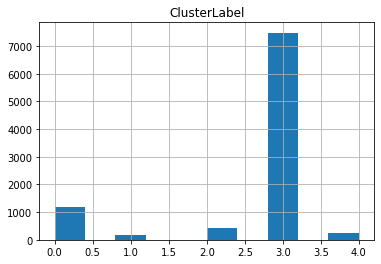

In [28]:
print(reviews.groupby(['ClusterLabel'])['Text'].count())
                       
reviews.hist(column='ClusterLabel');

In [29]:
import matplotlib.pyplot as plt
 

In [30]:
from sklearn.decomposition import PCA

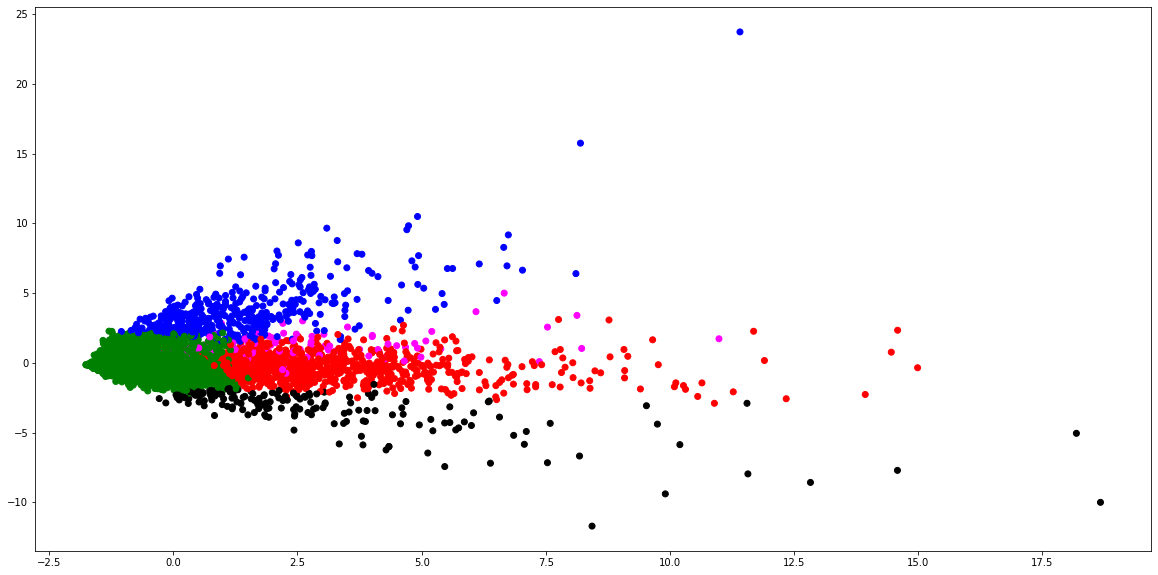

In [31]:
colors = ["red", "black", "blue", "green", "magenta"]

pca = PCA(n_components=2)

points = pca.fit_transform(bag_of_words.toarray())

x_axis = [point[0] for point in points]
y_axis = [point[1] for point in points]
fig, ax = plt.subplots(figsize=(20,10))

ax.scatter(x_axis, y_axis, c=[colors[i] for i in labels])


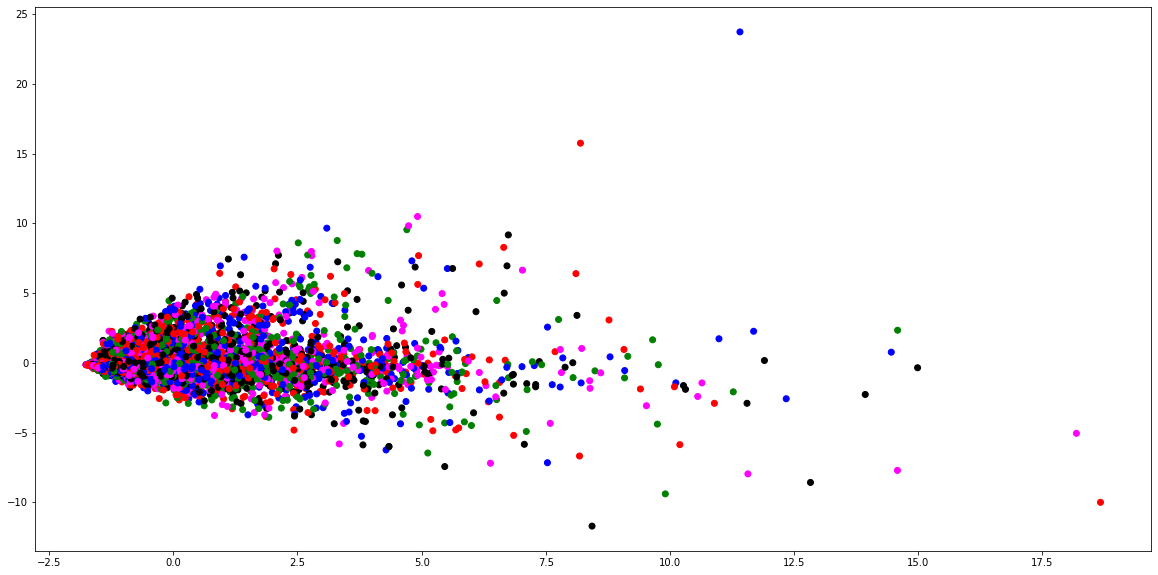

In [32]:
fig_bow_random, ax_bow_random = plt.subplots(figsize=(20,10))

random_chance = []
for i in range(9515):
    random_chance.append(random.randrange(5))

ax_bow_random.scatter(x_axis, y_axis, c=[colors[i] for i in random_chance])

(array([1611.,    0., 1538.,    0., 1558.,    0., 1676.,    0., 1558.,
        1574.]),
 array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ]),
 <BarContainer object of 10 artists>)

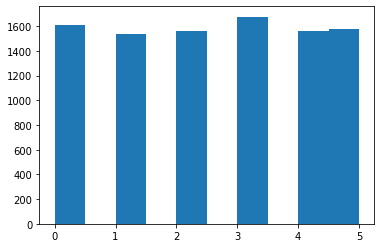

In [35]:
randomizer_data = [random.randint(0, 5) for i in range(1,9516)]
plt.hist(randomizer_data)

In [23]:
# to be added more visualization types if time allows

In [24]:
model = KMeans(n_clusters = 5, random_state=7)
model.fit(tfidf)

KMeans(n_clusters=5, random_state=7)

In [25]:
tf_labels = model.labels_
tf_cluster_center=model.cluster_centers_

In [26]:
reviews['ClusterLabelTF'] = tf_labels
reviews

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,ProcessedText,ClusterLabel,ClusterLabelTF
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,buy several vitality can dog food product find...,3,1
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,product arrive label jumbo salt peanutsthe pea...,3,4
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,confection around century light pillowy citrus...,3,4
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,look secret ingredient robitussin believe find...,3,4
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...,great taffy great price wide assortment yummy ...,3,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,B000P41A28,A3A63RACXR1XIL,"A. Boodhoo ""deaddodo""",10,15,1,1204502400,constipation,we switched from the advance similac to the or...,switch advance similac organic product thinkin...,3,4
9996,9997,B000P41A28,A5VVRGL8JA7R,Adam,2,3,5,1306368000,Constipation Not A Problem if...,"Like the bad reviews say, the organic formula ...",like bad review say organic formula constipate...,3,4
9997,9998,B000P41A28,A2TGDTJ8YCU6PD,geena77,0,0,5,1347494400,Love this formula!,I wanted to solely breastfeed but was unable t...,want solely breastfeed unable keep supplement ...,3,4
9998,9999,B000P41A28,AUV4GIZZE693O,"Susan Coe ""sueysis""",1,2,5,1203638400,very convenient,i love the fact that i can get this delieved t...,love fact get delieve house delievy chargeit h...,3,4


ClusterLabelTF
0     821
1     694
2     479
3    1085
4    6436
Name: Text, dtype: int64


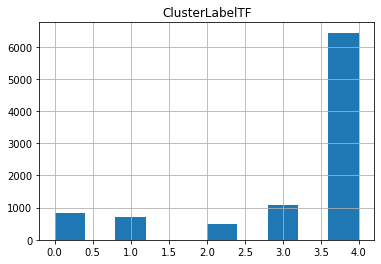

In [27]:
print(reviews.groupby(['ClusterLabelTF'])['Text'].count())
                       
reviews.hist(column='ClusterLabelTF');

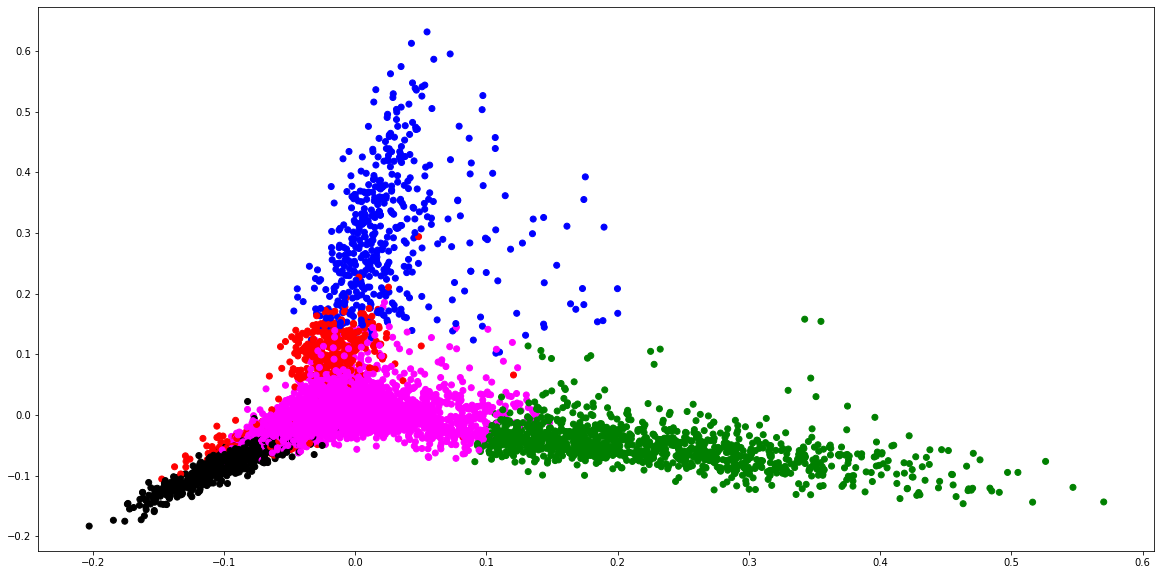

In [28]:
pca_tf = PCA(n_components=2)

points_tf = pca_tf.fit_transform(tfidf.toarray())

x_axis_tf = [point[0] for point in points_tf]
y_axis_tf = [point[1] for point in points_tf]
fig_tf, ax_tf = plt.subplots(figsize=(20,10))

ax_tf.scatter(x_axis_tf, y_axis_tf, c=[colors[i] for i in tf_labels])

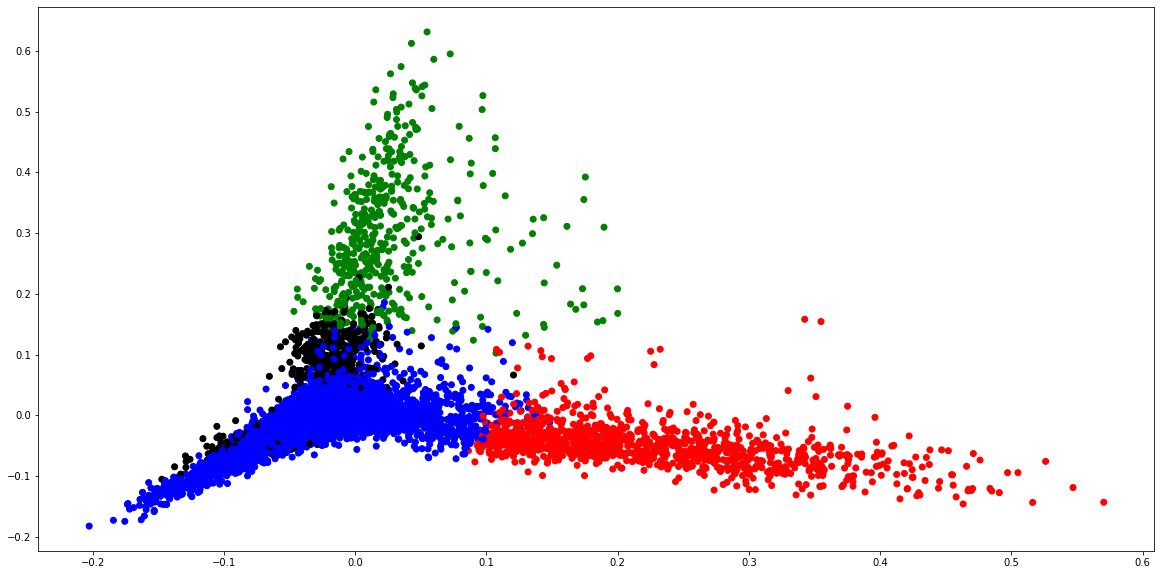

In [73]:
model = KMeans(n_clusters = 4, random_state=7)
model.fit(tfidf)

tfidf_labels = model.labels_
tfidf_cluster_center=model.cluster_centers_

pca_tfidf = PCA(n_components=2)

points_tfidf = pca_tfidf.fit_transform(tfidf.toarray())

x_axis_tfidf = [point[0] for point in points_tfidf]
y_axis_tfidf = [point[1] for point in points_tfidf]
fig_tfidf, ax_tfidf = plt.subplots(figsize=(20,10))

colors10 = ["red", "black", "blue", "green", "magenta", "orange", "lime", "turquoise", "salmon", "indigo"]

ax_tfidf.scatter(x_axis_tfidf, y_axis_tfidf, c=[colors10[i] for i in tfidf_labels])

2. Agglomerative clustering

In [37]:
from sklearn.cluster import AgglomerativeClustering

clustering = AgglomerativeClustering(n_clusters=5)
clustering.fit(bag_of_words.toarray())

agg_labels = clustering.labels_

In [80]:
reviews['ClusterLabelAgg'] = agg_labels
reviews

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,ProcessedText,ClusterLabel,ClusterLabelTF,ClusterLabelAgg
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,buy several vitality can dog food product find...,3,1,1
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,product arrive label jumbo salt peanutsthe pea...,3,4,1
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,confection around century light pillowy citrus...,3,4,1
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,look secret ingredient robitussin believe find...,3,4,1
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...,great taffy great price wide assortment yummy ...,3,4,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,B000P41A28,A3A63RACXR1XIL,"A. Boodhoo ""deaddodo""",10,15,1,1204502400,constipation,we switched from the advance similac to the or...,switch advance similac organic product thinkin...,3,4,1
9996,9997,B000P41A28,A5VVRGL8JA7R,Adam,2,3,5,1306368000,Constipation Not A Problem if...,"Like the bad reviews say, the organic formula ...",like bad review say organic formula constipate...,3,4,1
9997,9998,B000P41A28,A2TGDTJ8YCU6PD,geena77,0,0,5,1347494400,Love this formula!,I wanted to solely breastfeed but was unable t...,want solely breastfeed unable keep supplement ...,3,4,1
9998,9999,B000P41A28,AUV4GIZZE693O,"Susan Coe ""sueysis""",1,2,5,1203638400,very convenient,i love the fact that i can get this delieved t...,love fact get delieve house delievy chargeit h...,3,4,1


ClusterLabelAgg
0     732
1    8211
2     163
3     365
4      44
Name: Text, dtype: int64


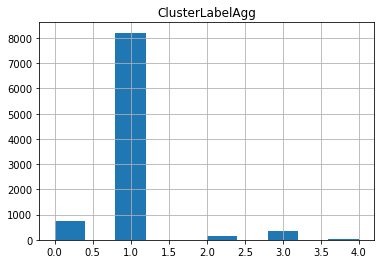

In [81]:
print(reviews.groupby(['ClusterLabelAgg'])['Text'].count())
                       
reviews.hist(column='ClusterLabelAgg');

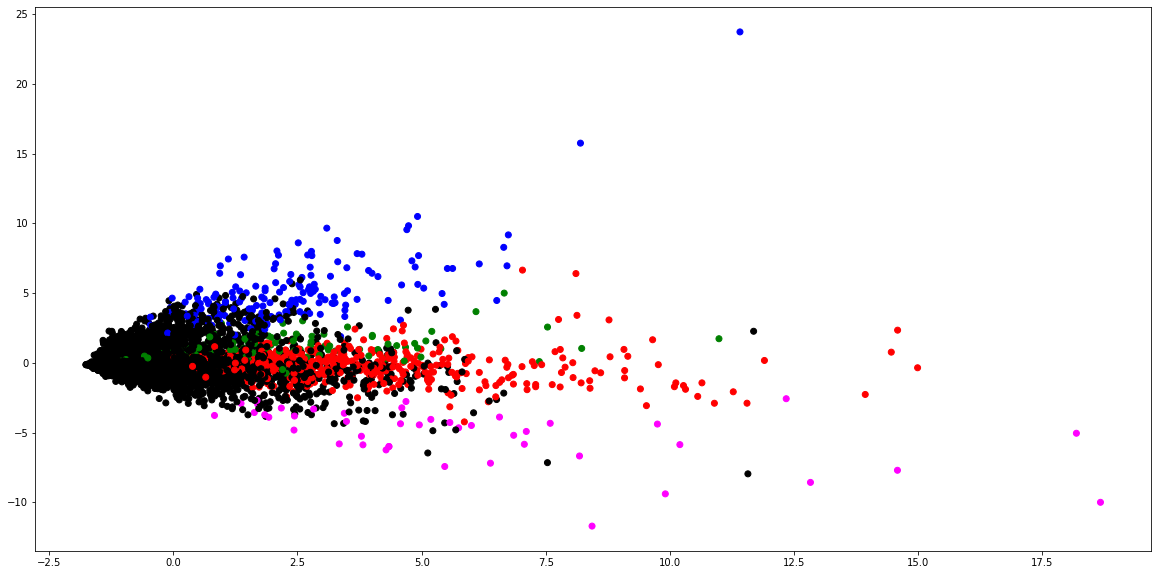

In [84]:
pca_agg = PCA(n_components=2)

points_agg = pca_agg.fit_transform(bag_of_words.toarray())

x_axis_agg = [point[0] for point in points_agg]
y_axis_agg = [point[1] for point in points_agg]
fig_agg, ax_agg = plt.subplots(figsize=(20,10))

ax_agg.scatter(x_axis_agg, y_axis_agg, c=[colors10[i] for i in agg_labels])

In [85]:
clustering = AgglomerativeClustering(n_clusters=5)
clustering.fit(tfidf.toarray())

agg_labels_tf = clustering.labels_

         Id   ProductId          UserId                      ProfileName  \
0         1  B001E4KFG0  A3SGXH7AUHU8GW                       delmartian   
1         2  B00813GRG4  A1D87F6ZCVE5NK                           dll pa   
2         3  B000LQOCH0   ABXLMWJIXXAIN  Natalia Corres "Natalia Corres"   
3         4  B000UA0QIQ  A395BORC6FGVXV                             Karl   
4         5  B006K2ZZ7K  A1UQRSCLF8GW1T    Michael D. Bigham "M. Wassir"   
...     ...         ...             ...                              ...   
9995   9996  B000P41A28  A3A63RACXR1XIL            A. Boodhoo "deaddodo"   
9996   9997  B000P41A28    A5VVRGL8JA7R                             Adam   
9997   9998  B000P41A28  A2TGDTJ8YCU6PD                          geena77   
9998   9999  B000P41A28   AUV4GIZZE693O              Susan Coe "sueysis"   
9999  10000  B000P41A28   A82WIMR4RSVLI                       Emrose mom   

      HelpfulnessNumerator  HelpfulnessDenominator  Score        Time  \
0             

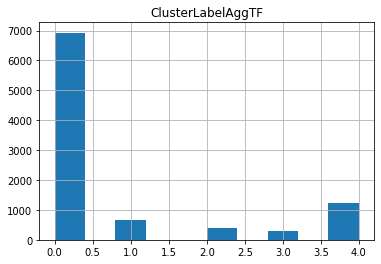

In [86]:
reviews['ClusterLabelAggTF'] = agg_labels_tf
print(reviews)

print(reviews.groupby(['ClusterLabelAggTF'])['Text'].count())
                       
reviews.hist(column='ClusterLabelAggTF');

NameError: name 'agg_labels_tf' is not defined

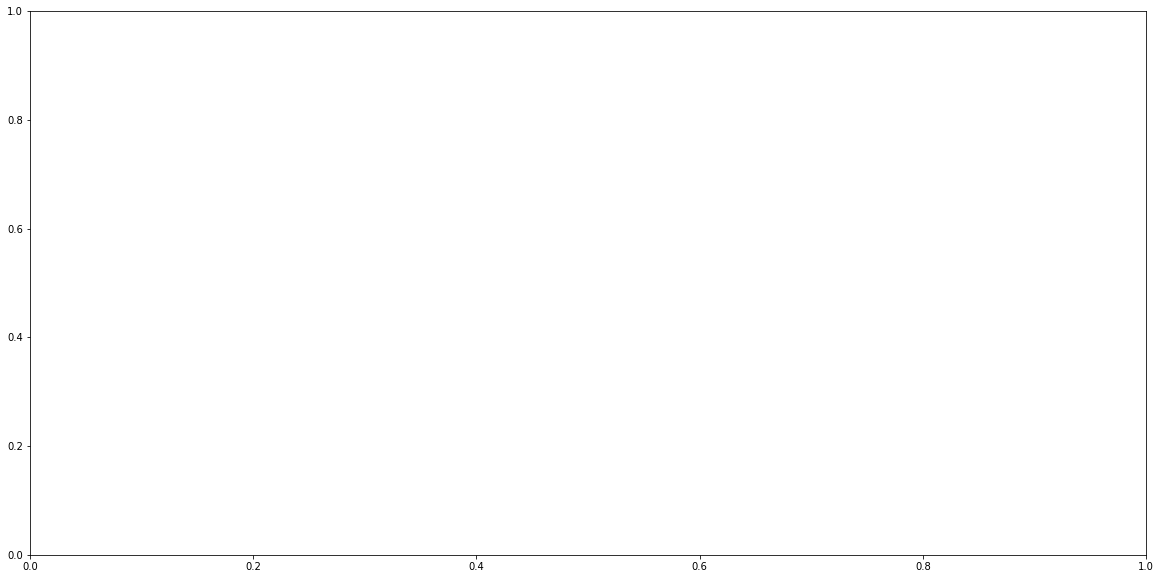

In [20]:
pca_agg_tf = PCA(n_components=2)

points_agg_tf = pca_agg_tf.fit_transform(tfidf.toarray())

x_axis_agg_tf = [point[0] for point in points_agg_tf]
y_axis_agg_tf = [point[1] for point in points_agg_tf]

fig_agg_tf, ax_agg_tf = plt.subplots(figsize=(20,10))

ax_agg_tf.scatter(x_axis_agg_tf, y_axis_agg_tf, c=[colors10[i] for i in agg_labels_tf])

In [13]:
import random

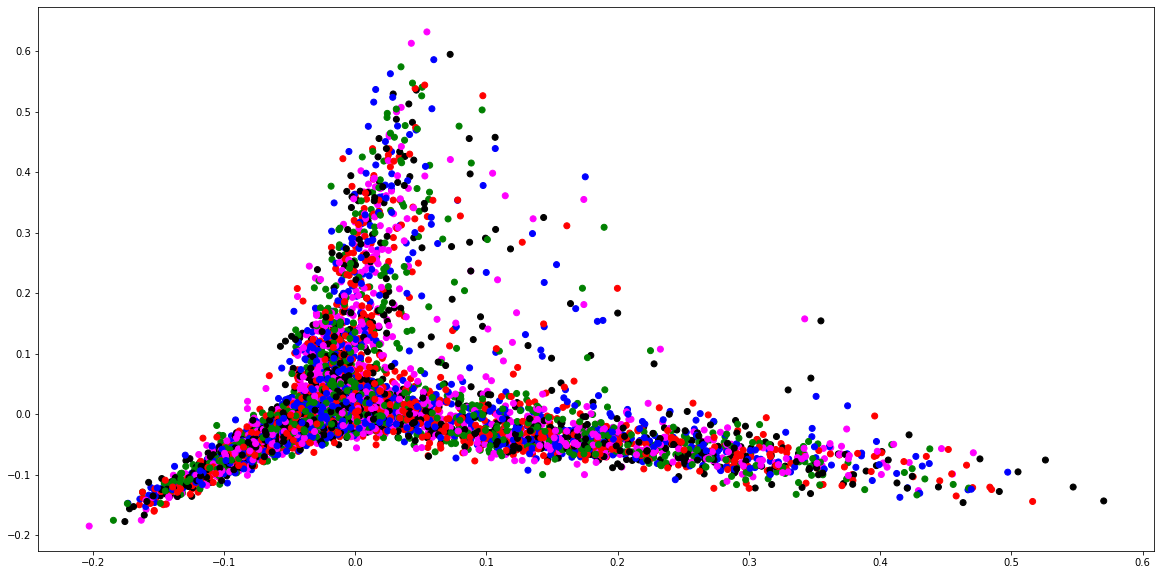

In [21]:
fig_agg_tf_random, ax_agg_tf_random = plt.subplots(figsize=(20,10))

random_chance = []
for i in range(9515):
    random_chance.append(random.randrange(5))

ax_agg_tf_random.scatter(x_axis_agg_tf, y_axis_agg_tf, c=[colors[i] for i in random_chance])

In [ ]:
fig_agg_tf_random, ax_agg_tf_random = plt.subplots(figsize=(20,10))

random_chance = []
for i in range(9515):
    random_chance.append(random.randrange(5))

ax_agg_tf_random.scatter(x_axis_agg_tf, y_axis_agg_tf, c=[colors[i] for i in random_chance])

## Elbow method

In [97]:
distortions = []
K = range(1,20)

for k in K:
    model = KMeans(n_clusters = k)
    model.fit(bag_of_words)
    distortions.append(model.inertia_)

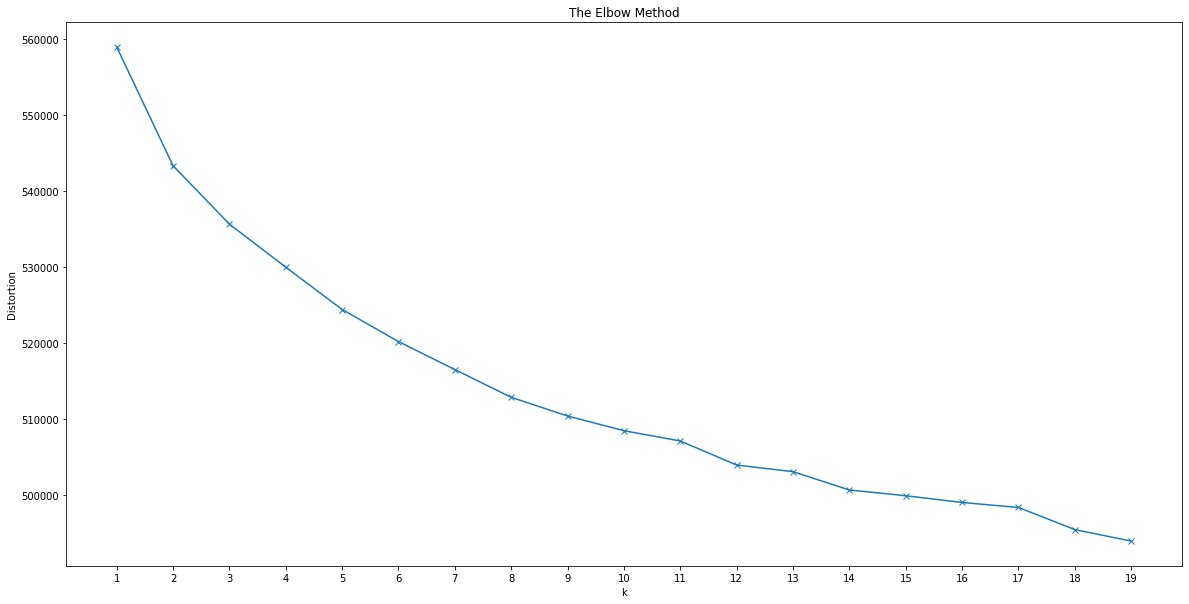

In [103]:
plt.figure(figsize=(20,10))
plt.plot(K, distortions, marker='x', markerfacecolor="green")
plt.xticks(K, K)
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method')
plt.show()

In [104]:
distortions_tf = []
K = range(1,11)

for k in K:
    model = KMeans(n_clusters = k)
    model.fit(tfidf)
    distortions_tf.append(model.inertia_)

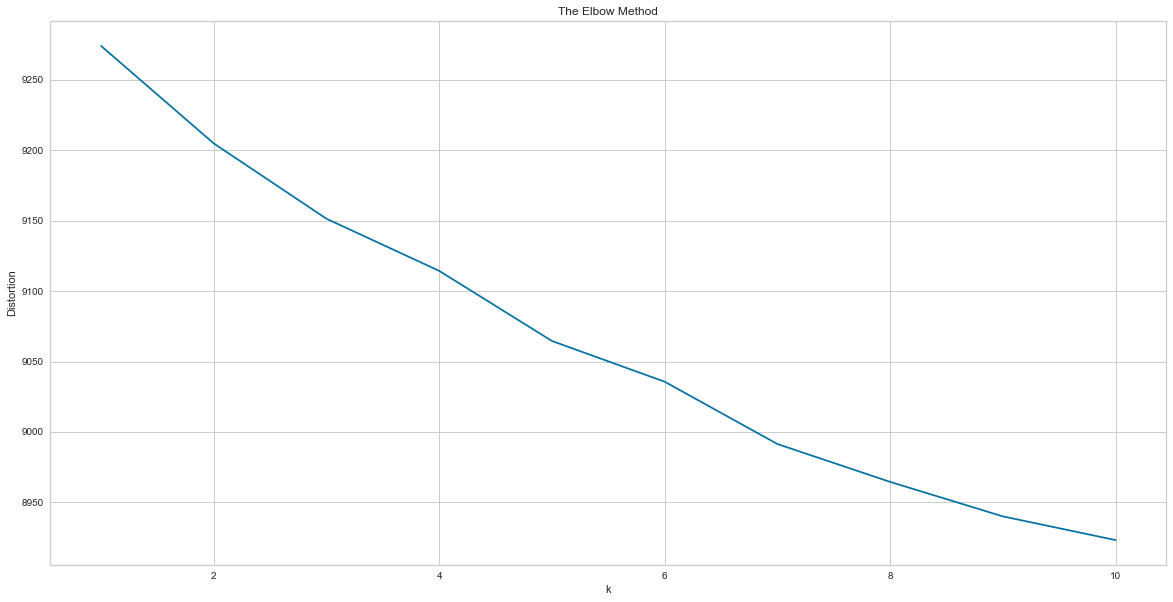

In [112]:
plt.figure(figsize=(20,10))
plt.plot(K, distortions_tf, marker='x', markerfacecolor="green")
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method')
plt.show()

## another Elbow Method

In [74]:
!pip install yellowbrick  

from yellowbrick.cluster import KElbowVisualizer

In [107]:
model = KMeans(random_state=7)
visualizer = KElbowVisualizer(model, k=(2,11))

In [72]:
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

c:\python39\lib\site-packages\sklearn\utils\validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
c:\python39\lib\site-packages\sklearn\utils\validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
c:\python39\lib\site-packages\sklearn\utils\validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
c:\python39\lib\site-packages\sklearn\utils\validation.py:593: FutureWarn

c:\python39\lib\site-packages\sklearn\utils\validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
c:\python39\lib\site-packages\sklearn\utils\validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
c:\python39\lib\site-packages\sklearn\utils\validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
c:\python39\lib\site-packages\sklearn\utils\validation.py:593: FutureWarn

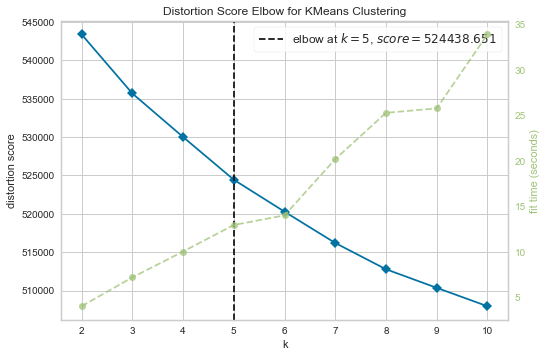

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [108]:
visualizer.fit(bag_of_words)
visualizer.show()

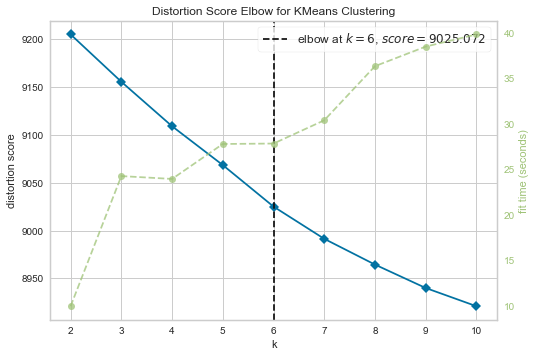

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [110]:
model = KMeans(random_state=7)
visualizer = KElbowVisualizer(model, k=(2,11))

visualizer.fit(tfidf)
visualizer.show()

## Comparison with Supervised model 

In [23]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import metrics, svm, preprocessing

In [24]:
reviews["Score"]

0       5
1       1
2       4
3       2
4       5
       ..
9995    1
9996    5
9997    5
9998    5
9999    4
Name: Score, Length: 9515, dtype: int64

In [25]:
bag_of_words

<9515x23469 sparse matrix of type '<class 'numpy.int64'>'
	with 307717 stored elements in Compressed Sparse Row format>

In [37]:
# splitting the data

X_train, X_test, y_train, y_test = train_test_split(reviews["ProcessedText"], reviews["Score"], test_size=0.2, random_state=7)
print(1)

y_train, y_test = np.array(y_train), np.array(y_test)

vector_bow_limited = CountVectorizer(max_features = 8622)

X_train_bow, X_test_bow = vector_bow_limited.fit_transform(X_train), vector_bow.fit_transform(X_test)
print(2)

classifier = svm.SVC()
classifier.fit(X_train_bow, y_train)
print(3)


1
2
3


In [38]:
score1 = classifier.score(X_test_bow, y_test)
print("scor SVM ", score1)

scor SVM  0.6227009984235418


In [39]:
bow_predictions = classifier.predict(X_test_bow)

In [38]:
from sklearn.metrics import silhouette_score

In [43]:
bow_predictions

array([5, 5, 5, ..., 5, 5, 5], dtype=int64)

In [48]:
silhouette = silhouette_score(bag_of_words, model.predict(bag_of_words))

In [49]:
silhouette

0.20651120392737654

In [40]:
silhouette = silhouette_score(bag_of_words, agg_labels)

In [41]:
silhouette

0.12466913621874047

In [43]:
clustering2 = AgglomerativeClustering(n_clusters=5, affinity="manhattan", linkage="average")
clustering2.fit(bag_of_words.toarray())

agg_labels2 = clustering2.labels_

In [44]:
silhouette = silhouette_score(bag_of_words, agg_labels2)
silhouette

0.701562466236474

In [ ]:
pca_agg = PCA(n_components=2)

points_agg = pca_agg.fit_transform(bag_of_words.toarray())

x_axis_agg = [point[0] for point in points_agg]
y_axis_agg = [point[1] for point in points_agg]
fig_agg, ax_agg = plt.subplots(figsize=(20,10))

ax_agg.scatter(x_axis_agg, y_axis_agg, c=[colors[i] for i in agg_labels2])

In [45]:
clustering3 = AgglomerativeClustering(n_clusters=5)
clustering3.fit(tfidf.toarray())

agg_labels3 = clustering3.labels_

In [46]:
silhouette = silhouette_score(bag_of_words, agg_labels3)
silhouette

0.0074171872380634106

In [ ]:
clustering4 = AgglomerativeClustering(n_clusters=5, affinity="manhattan", linkage="average")
clustering4.fit(tfidf.toarray())

agg_labels4 = clustering4.labels_

In [ ]:
silhouette = silhouette_score(bag_of_words, agg_labels3)
silhouette

## Grid Search

In [60]:
hyperparams = {
    "n_clusters": [4, 5, 6],
    "n_init": [1, 5, 10, 15],
    "max_iter": [200, 300, 400],
    "tol": [.000001, .00001, .0001],
}

In [54]:
from sklearn.model_selection import GridSearchCV

In [61]:
k_means = KMeans()

grid_kmeans = GridSearchCV(
    estimator = k_means,
    param_grid = hyperparams,
    verbose = 3
)

In [62]:
grid_kmeans.fit(bag_of_words)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
[CV 1/5] END max_iter=200, n_clusters=4, n_init=1, tol=1e-06;, score=-103403.591 total time=   0.4s
[CV 2/5] END max_iter=200, n_clusters=4, n_init=1, tol=1e-06;, score=-104737.915 total time=   0.6s
[CV 3/5] END max_iter=200, n_clusters=4, n_init=1, tol=1e-06;, score=-107732.639 total time=   0.7s
[CV 4/5] END max_iter=200, n_clusters=4, n_init=1, tol=1e-06;, score=-116230.357 total time=   1.0s
[CV 5/5] END max_iter=200, n_clusters=4, n_init=1, tol=1e-06;, score=-108126.830 total time=   0.6s
[CV 1/5] END max_iter=200, n_clusters=4, n_init=1, tol=1e-05;, score=-102835.349 total time=   0.6s
[CV 2/5] END max_iter=200, n_clusters=4, n_init=1, tol=1e-05;, score=-104718.383 total time=   0.7s
[CV 3/5] END max_iter=200, n_clusters=4, n_init=1, tol=1e-05;, score=-107987.454 total time=   0.7s
[CV 4/5] END max_iter=200, n_clusters=4, n_init=1, tol=1e-05;, score=-115156.208 total time=   1.0s
[CV 5/5] END max_iter=200, n_clusters

[CV 2/5] END max_iter=200, n_clusters=5, n_init=5, tol=1e-05;, score=-103890.007 total time=   6.2s
[CV 3/5] END max_iter=200, n_clusters=5, n_init=5, tol=1e-05;, score=-106838.674 total time=   7.2s
[CV 4/5] END max_iter=200, n_clusters=5, n_init=5, tol=1e-05;, score=-114884.109 total time=   4.3s
[CV 5/5] END max_iter=200, n_clusters=5, n_init=5, tol=1e-05;, score=-106509.283 total time=   6.1s
[CV 1/5] END max_iter=200, n_clusters=5, n_init=5, tol=0.0001;, score=-102557.879 total time=   7.2s
[CV 2/5] END max_iter=200, n_clusters=5, n_init=5, tol=0.0001;, score=-103888.352 total time=   6.7s
[CV 3/5] END max_iter=200, n_clusters=5, n_init=5, tol=0.0001;, score=-108566.977 total time=   4.8s
[CV 4/5] END max_iter=200, n_clusters=5, n_init=5, tol=0.0001;, score=-113825.389 total time=   5.3s
[CV 5/5] END max_iter=200, n_clusters=5, n_init=5, tol=0.0001;, score=-107215.401 total time=   6.3s
[CV 1/5] END max_iter=200, n_clusters=5, n_init=10, tol=1e-06;, score=-102557.970 total time=  

[CV 4/5] END max_iter=200, n_clusters=6, n_init=10, tol=0.0001;, score=-113664.859 total time=  13.5s
[CV 5/5] END max_iter=200, n_clusters=6, n_init=10, tol=0.0001;, score=-105550.051 total time=  15.9s
[CV 1/5] END max_iter=200, n_clusters=6, n_init=15, tol=1e-06;, score=-101573.075 total time=  20.7s
[CV 2/5] END max_iter=200, n_clusters=6, n_init=15, tol=1e-06;, score=-102517.350 total time=  21.2s
[CV 3/5] END max_iter=200, n_clusters=6, n_init=15, tol=1e-06;, score=-106224.393 total time=  17.3s
[CV 4/5] END max_iter=200, n_clusters=6, n_init=15, tol=1e-06;, score=-113522.062 total time=  18.3s
[CV 5/5] END max_iter=200, n_clusters=6, n_init=15, tol=1e-06;, score=-105570.447 total time=  18.6s
[CV 1/5] END max_iter=200, n_clusters=6, n_init=15, tol=1e-05;, score=-101832.717 total time=  17.0s
[CV 2/5] END max_iter=200, n_clusters=6, n_init=15, tol=1e-05;, score=-102510.343 total time=  23.8s
[CV 3/5] END max_iter=200, n_clusters=6, n_init=15, tol=1e-05;, score=-106236.872 total t

[CV 1/5] END max_iter=300, n_clusters=5, n_init=1, tol=1e-05;, score=-102920.515 total time=   1.0s
[CV 2/5] END max_iter=300, n_clusters=5, n_init=1, tol=1e-05;, score=-104094.405 total time=   0.6s
[CV 3/5] END max_iter=300, n_clusters=5, n_init=1, tol=1e-05;, score=-107021.207 total time=   0.6s
[CV 4/5] END max_iter=300, n_clusters=5, n_init=1, tol=1e-05;, score=-115922.539 total time=   1.0s
[CV 5/5] END max_iter=300, n_clusters=5, n_init=1, tol=1e-05;, score=-108123.839 total time=   1.3s
[CV 1/5] END max_iter=300, n_clusters=5, n_init=1, tol=0.0001;, score=-102852.775 total time=   0.7s
[CV 2/5] END max_iter=300, n_clusters=5, n_init=1, tol=0.0001;, score=-103918.864 total time=   2.0s
[CV 3/5] END max_iter=300, n_clusters=5, n_init=1, tol=0.0001;, score=-109387.455 total time=   0.5s
[CV 4/5] END max_iter=300, n_clusters=5, n_init=1, tol=0.0001;, score=-114696.368 total time=   1.1s
[CV 5/5] END max_iter=300, n_clusters=5, n_init=1, tol=0.0001;, score=-109051.572 total time=   

[CV 3/5] END max_iter=300, n_clusters=6, n_init=5, tol=0.0001;, score=-107829.102 total time=   5.2s
[CV 4/5] END max_iter=300, n_clusters=6, n_init=5, tol=0.0001;, score=-113569.565 total time=   5.7s
[CV 5/5] END max_iter=300, n_clusters=6, n_init=5, tol=0.0001;, score=-105376.055 total time=   8.9s
[CV 1/5] END max_iter=300, n_clusters=6, n_init=10, tol=1e-06;, score=-102567.156 total time=  11.8s
[CV 2/5] END max_iter=300, n_clusters=6, n_init=10, tol=1e-06;, score=-102507.968 total time=  12.6s
[CV 3/5] END max_iter=300, n_clusters=6, n_init=10, tol=1e-06;, score=-105759.811 total time=  12.9s
[CV 4/5] END max_iter=300, n_clusters=6, n_init=10, tol=1e-06;, score=-113684.009 total time=  11.4s
[CV 5/5] END max_iter=300, n_clusters=6, n_init=10, tol=1e-06;, score=-106350.685 total time=  14.2s
[CV 1/5] END max_iter=300, n_clusters=6, n_init=10, tol=1e-05;, score=-101565.861 total time=  15.8s
[CV 2/5] END max_iter=300, n_clusters=6, n_init=10, tol=1e-05;, score=-103754.556 total tim

[CV 5/5] END max_iter=400, n_clusters=4, n_init=15, tol=1e-06;, score=-106698.019 total time=  15.1s
[CV 1/5] END max_iter=400, n_clusters=4, n_init=15, tol=1e-05;, score=-102849.152 total time=  11.8s
[CV 2/5] END max_iter=400, n_clusters=4, n_init=15, tol=1e-05;, score=-104723.534 total time=  15.2s
[CV 3/5] END max_iter=400, n_clusters=4, n_init=15, tol=1e-05;, score=-107749.121 total time=  12.9s
[CV 4/5] END max_iter=400, n_clusters=4, n_init=15, tol=1e-05;, score=-115044.392 total time=  11.2s
[CV 5/5] END max_iter=400, n_clusters=4, n_init=15, tol=1e-05;, score=-108783.189 total time=  11.2s
[CV 1/5] END max_iter=400, n_clusters=4, n_init=15, tol=0.0001;, score=-103394.573 total time=  14.5s
[CV 2/5] END max_iter=400, n_clusters=4, n_init=15, tol=0.0001;, score=-104725.495 total time=  11.9s
[CV 3/5] END max_iter=400, n_clusters=4, n_init=15, tol=0.0001;, score=-107461.534 total time=  10.7s
[CV 4/5] END max_iter=400, n_clusters=4, n_init=15, tol=0.0001;, score=-115060.309 total

[CV 2/5] END max_iter=400, n_clusters=6, n_init=1, tol=0.0001;, score=-104022.129 total time=   0.8s
[CV 3/5] END max_iter=400, n_clusters=6, n_init=1, tol=0.0001;, score=-107598.708 total time=   1.0s
[CV 4/5] END max_iter=400, n_clusters=6, n_init=1, tol=0.0001;, score=-115894.906 total time=   1.6s
[CV 5/5] END max_iter=400, n_clusters=6, n_init=1, tol=0.0001;, score=-105718.060 total time=   0.8s
[CV 1/5] END max_iter=400, n_clusters=6, n_init=5, tol=1e-06;, score=-101558.768 total time=   5.7s
[CV 2/5] END max_iter=400, n_clusters=6, n_init=5, tol=1e-06;, score=-103877.682 total time=   5.8s
[CV 3/5] END max_iter=400, n_clusters=6, n_init=5, tol=1e-06;, score=-106637.554 total time=   5.9s
[CV 4/5] END max_iter=400, n_clusters=6, n_init=5, tol=1e-06;, score=-113653.043 total time=   6.2s
[CV 5/5] END max_iter=400, n_clusters=6, n_init=5, tol=1e-06;, score=-108444.272 total time=   6.1s
[CV 1/5] END max_iter=400, n_clusters=6, n_init=5, tol=1e-05;, score=-101719.419 total time=   6

GridSearchCV(estimator=KMeans(),
             param_grid={'max_iter': [200, 300, 400], 'n_clusters': [4, 5, 6],
                         'n_init': [1, 5, 10, 15],
                         'tol': [1e-06, 1e-05, 0.0001]},
             verbose=3)

In [64]:
grid_kmeans.best_params_

{'max_iter': 300, 'n_clusters': 6, 'n_init': 15, 'tol': 0.0001}

In [65]:
grid_kmeans.best_score_

-105805.18568463542

In [67]:
hyperparams_tf = {
    "n_clusters": [4, 5, 6],
    "n_init": [1, 5, 10, 15],
    "max_iter": [200, 300],
    "tol": [.00001, .0001],
}

In [68]:
k_means = KMeans()

grid_kmeans = GridSearchCV(
    estimator = k_means,
    param_grid = hyperparams_tf,
    verbose = 3
)

In [69]:
grid_kmeans.fit(tfidf)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV 1/5] END max_iter=200, n_clusters=4, n_init=1, tol=1e-05;, score=-1853.358 total time=   1.2s
[CV 2/5] END max_iter=200, n_clusters=4, n_init=1, tol=1e-05;, score=-1835.611 total time=   0.7s
[CV 3/5] END max_iter=200, n_clusters=4, n_init=1, tol=1e-05;, score=-1839.481 total time=   1.0s
[CV 4/5] END max_iter=200, n_clusters=4, n_init=1, tol=1e-05;, score=-1840.682 total time=   1.4s
[CV 5/5] END max_iter=200, n_clusters=4, n_init=1, tol=1e-05;, score=-1833.664 total time=   1.1s
[CV 1/5] END max_iter=200, n_clusters=4, n_init=1, tol=0.0001;, score=-1844.314 total time=   0.8s
[CV 2/5] END max_iter=200, n_clusters=4, n_init=1, tol=0.0001;, score=-1834.612 total time=   0.6s
[CV 3/5] END max_iter=200, n_clusters=4, n_init=1, tol=0.0001;, score=-1842.787 total time=   0.6s
[CV 4/5] END max_iter=200, n_clusters=4, n_init=1, tol=0.0001;, score=-1841.677 total time=   1.1s
[CV 5/5] END max_iter=200, n_clusters=4, n_init=1, t

[CV 4/5] END max_iter=200, n_clusters=6, n_init=1, tol=1e-05;, score=-1828.590 total time=   2.1s
[CV 5/5] END max_iter=200, n_clusters=6, n_init=1, tol=1e-05;, score=-1819.522 total time=   4.7s
[CV 1/5] END max_iter=200, n_clusters=6, n_init=1, tol=0.0001;, score=-1841.642 total time=   1.4s
[CV 2/5] END max_iter=200, n_clusters=6, n_init=1, tol=0.0001;, score=-1825.792 total time=   2.0s
[CV 3/5] END max_iter=200, n_clusters=6, n_init=1, tol=0.0001;, score=-1824.452 total time=   1.4s
[CV 4/5] END max_iter=200, n_clusters=6, n_init=1, tol=0.0001;, score=-1830.514 total time=   4.0s
[CV 5/5] END max_iter=200, n_clusters=6, n_init=1, tol=0.0001;, score=-1819.975 total time=   1.5s
[CV 1/5] END max_iter=200, n_clusters=6, n_init=5, tol=1e-05;, score=-1837.953 total time=  14.9s
[CV 2/5] END max_iter=200, n_clusters=6, n_init=5, tol=1e-05;, score=-1828.692 total time=   8.7s
[CV 3/5] END max_iter=200, n_clusters=6, n_init=5, tol=1e-05;, score=-1835.097 total time=  12.6s
[CV 4/5] END ma

[CV 2/5] END max_iter=300, n_clusters=5, n_init=1, tol=0.0001;, score=-1835.003 total time=   1.4s
[CV 3/5] END max_iter=300, n_clusters=5, n_init=1, tol=0.0001;, score=-1828.359 total time=   2.2s
[CV 4/5] END max_iter=300, n_clusters=5, n_init=1, tol=0.0001;, score=-1838.873 total time=   1.2s
[CV 5/5] END max_iter=300, n_clusters=5, n_init=1, tol=0.0001;, score=-1828.107 total time=   1.8s
[CV 1/5] END max_iter=300, n_clusters=5, n_init=5, tol=1e-05;, score=-1845.310 total time=  10.5s
[CV 2/5] END max_iter=300, n_clusters=5, n_init=5, tol=1e-05;, score=-1842.227 total time=   8.9s
[CV 3/5] END max_iter=300, n_clusters=5, n_init=5, tol=1e-05;, score=-1836.666 total time=  13.5s
[CV 4/5] END max_iter=300, n_clusters=5, n_init=5, tol=1e-05;, score=-1831.354 total time=  11.0s
[CV 5/5] END max_iter=300, n_clusters=5, n_init=5, tol=1e-05;, score=-1833.190 total time=  11.4s
[CV 1/5] END max_iter=300, n_clusters=5, n_init=5, tol=0.0001;, score=-1847.639 total time=  13.0s
[CV 2/5] END ma

GridSearchCV(estimator=KMeans(),
             param_grid={'max_iter': [200, 300], 'n_clusters': [4, 5, 6],
                         'n_init': [1, 5, 10, 15], 'tol': [1e-05, 0.0001]},
             verbose=3)

In [70]:
grid_kmeans.best_params_

{'max_iter': 300, 'n_clusters': 6, 'n_init': 1, 'tol': 0.0001}

In [71]:
grid_kmeans.best_score_

-1827.0624662389007

In [77]:
model = KMeans(random_state=7)
visualizer = KElbowVisualizer(model, k=(3,10))

c:\python39\lib\site-packages\yellowbrick\utils\kneed.py:156: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
c:\python39\lib\site-packages\yellowbrick\cluster\elbow.py:374: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.warn(warning_message, YellowbrickWarning)


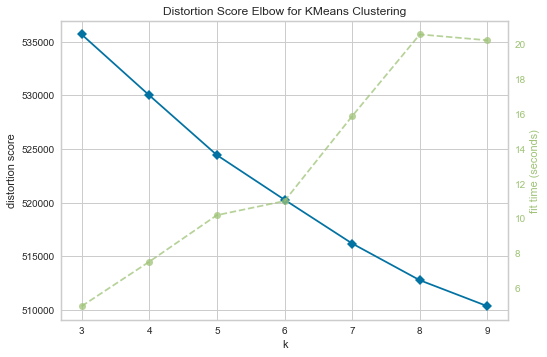

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [78]:
visualizer.fit(bag_of_words)
visualizer.show()

In [79]:
from sklearn.cluster import AgglomerativeClustering

clustering = AgglomerativeClustering()

In [84]:
hyperparams_agg = {
    "n_clusters": [4, 5, 6],
    "linkage" : ["ward", "complete", "average", "single"]
}

In [87]:
agg = AgglomerativeClustering()

grid_agg = GridSearchCV(
    estimator = agg,
    param_grid = hyperparams_agg,
    scoring = "accuracy"
    verbose = 3
)

SyntaxError: invalid syntax (2341705884.py, line 7)

In [88]:
grid_agg.fit(bag_of_words)

TypeError: If no scoring is specified, the estimator passed should have a 'score' method. The estimator AgglomerativeClustering() does not.